In [24]:
import sys
import os
from pathlib import Path
sys.path.append("/Users/jdli/Project/Korg.jl/Jorg/src/")        
# from jorg.synthesis_streamlined import synth_streamlined
from jorg.synthesis import synth
from jorg.lines.linelist import read_linelist

linelist_path = "/Users/jdli/Project/Korg.jl/data/linelists/vald_extract_stellar_solar_threshold001.vald"
# linelist_path = Path("/Users/jdli/Project/Korg.jl/data/linelists/GALAH_DR3/galah_dr3_linelist.h5")
linelist = read_linelist(str(linelist_path))

/Users/jdli/Project/Korg.jl/Jorg/src/jorg/lines/linelist.py:208: UserWarning: Could not detect format for /Users/jdli/Project/Korg.jl/data/linelists/vald_extract_stellar_solar_threshold001.vald, assuming VALD
  warnings.warn(f"Could not detect format for {filename}, assuming VALD")


📖 Reading linelist: vald_extract_stellar_solar_threshold001.vald
   Format: vald
   Wavelength unit: auto
   Found 41880 data lines
   Successfully parsed 36197 lines


/Users/jdli/Project/Korg.jl/Jorg/src/jorg/lines/broadening_korg.py:210: RuntimeWarning: divide by zero encountered in log10
  log_gamma_vdW = (6.33 + 0.4 * np.log10(Delta_rbar2) +


In [25]:
wl, flux, cont = synth(
    5780, 4.44, 0.0, (5100, 5200),
    linelist=linelist, rectify=True,
    )

🔧 WAVELENGTH GRID: 20001 points, 5.0 mÅ spacing
✅ Preprocessed 18 molecular species for optimization


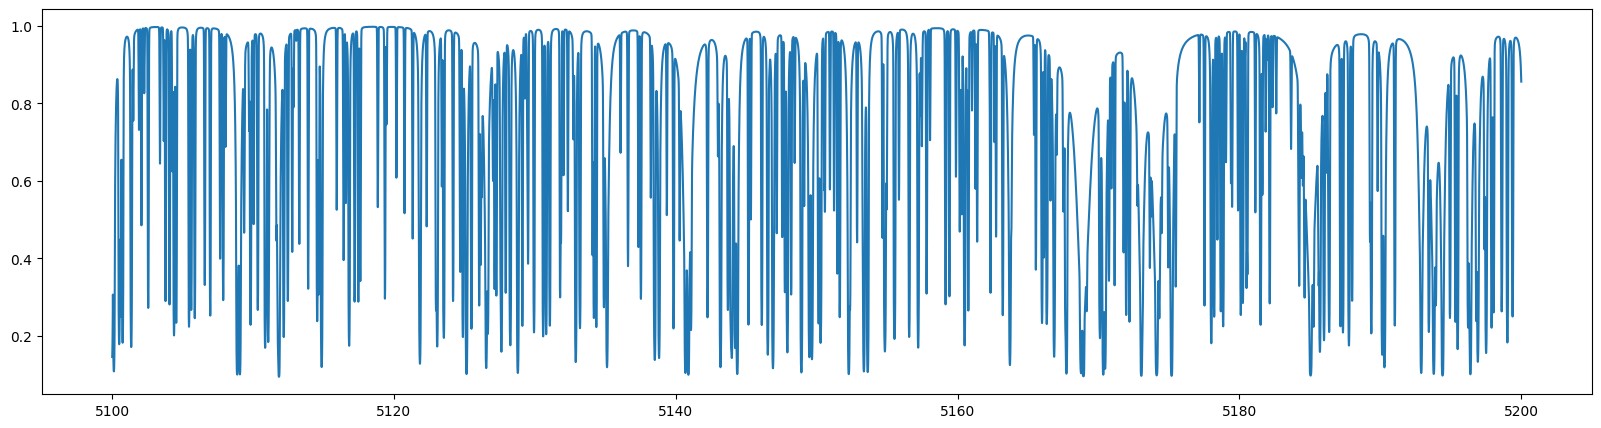

In [26]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(wl, flux)

In [15]:
import numpy as np
korg_flux = np.loadtxt("/Users/jdli/Project/Korg.jl/Jorg/korg_script/korg_spectrum.txt")

(5100.0, 5120.0)

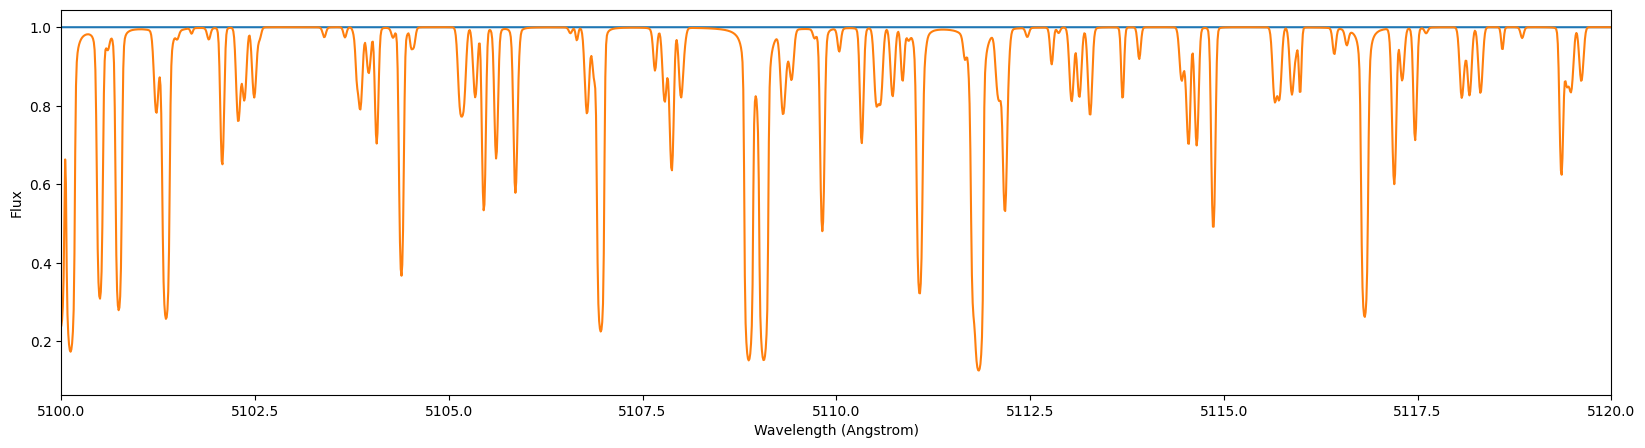

In [23]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(wl, flux)
plt.plot(korg_flux[:, 0], korg_flux[:, 1], label="Korg Flux")
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Flux")
# plt.xlim((5000, 5020))
# plt.xlim((5500, 5600))
plt.xlim((5100, 5120))

In [12]:
korg_flux

array([[5.00000e+03, 9.97413e-01],
       [5.00001e+03, 9.97491e-01],
       [5.00002e+03, 9.97549e-01],
       ...,
       [5.19998e+03, 9.82961e-01],
       [5.19999e+03, 9.81267e-01],
       [5.20000e+03, 9.79223e-01]])

In [28]:
from jorg.synthesis import synthesize, synthesize_korg_compatible, create_korg_compatible_abundance_array
from jorg.atmosphere import interpolate_marcs as interpolate_atmosphere


A_X = create_korg_compatible_abundance_array(0)
atm = interpolate_atmosphere(Teff=5780., logg=4.44, m_H=0)
jorg_result = synthesize(atm, linelist, A_X, wavelengths=(5000, 5020))

🚀 KORG-COMPATIBLE JORG SYNTHESIS
Using Jorg's validated physics within Korg's architecture
🔧 WAVELENGTH GRID: 4001 points, 5.0 mÅ spacing
Wavelength range: 5000.0 - 5020.0 Å (4001 points)
Abundances normalized: H fraction = 0.923902
✅ Preprocessed 18 molecular species for optimization
✅ Atomic physics data loaded
Atmospheric model: 56 layers
  Temperature range: 4068.6 - 9935.6 K
  Pressure range: 2.67e+02 - 2.18e+05 dyn/cm²

🧪 SYSTEMATIC LAYER-BY-LAYER PROCESSING
Using Jorg's validated physics within Korg's architecture...
🔄 Processing 56 atmospheric layers...
   Wavelengths: 4001 points (5000.0-5020.0 Å)
   Layer  1/56 (  1.8%)
   Layer  2/56 (  3.6%)
   Layer  3/56 (  5.4%)
   Layer  4/56 (  7.1%)
   Layer  5/56 (  8.9%)
   Layer 11/56 ( 19.6%)
   Layer 21/56 ( 37.5%)
   Layer 31/56 ( 55.4%)
   Layer 41/56 ( 73.2%)
   Layer 51/56 ( 91.1%)

✅ Layer processing complete:
   Layers processed: 56
   Chemical equilibrium failures: 0
   Continuum failures: 0
   Line failures: 0
   Processi

In [27]:
alpha_min = np.min(jorg_result.alpha, axis=1)
alpha_max = np.max(jorg_result.alpha, axis=1)
alpha_mean = np.mean(jorg_result.alpha, axis=1)

NameError: name 'jorg_result' is not defined

In [10]:
alpha_korg = np.loadtxt("/Users/jdli/Project/Korg.jl/Jorg/korg_script/korg_synthesize_opacity_summary.txt", 
                        comments="#", skiprows=3, usecols=( 1, 2, 3), )

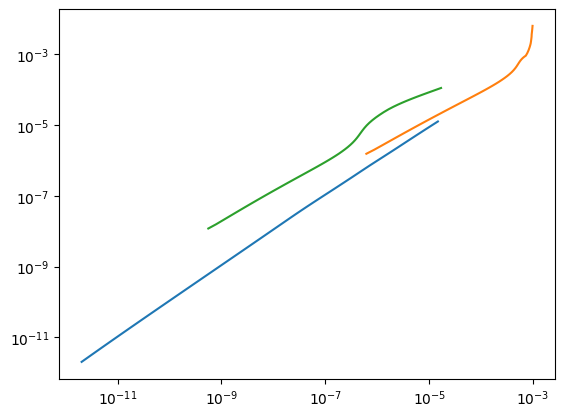

In [ ]:
plt.plot(alpha_korg[:56,0], alpha_min, label="Alpha Min")
plt.plot(alpha_korg[:56,1], alpha_max, label="Alpha Max")
plt.plot(alpha_korg[:56,2], alpha_mean, label="Alpha Mean")
plt.xscale('log')
plt.yscale('log')
plt.legend()
# plot one-to-one line
plt.plot([1e-11, 1e-2], [1e-11, 1e-2], color='red', linestyle='--', label='1:1')